<a href="https://colab.research.google.com/github/aditeyabaral/kepler-exoplanet-analysis/blob/master/src/Data_Cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint
import re

# Initialising libraires

In [2]:
pp = pprint.PrettyPrinter(indent = 3)

# Loading DataFrame

[Dataset URL](https://www.kaggle.com/nasa/kepler-exoplanet-search-results)<br>
[Link to Metadata](https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html)<br>
[Column Name Metadata](https://exoplanetarchive.ipac.caltech.edu/docs/API_keplerstellar_columns.html)

In [3]:
df = pd.read_csv("../data/kepler-data.csv")
print(df.shape)
df.head()

(9564, 50)


,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


# Counting NaN Values

In [4]:
nan_columns = df.isnull().sum()
nan_columns = {col:count for col, count in nan_columns.items() if count >0}

In [5]:
pp.pprint(nan_columns)

{  'kepler_name': 7270,
   'koi_depth': 363,
   'koi_depth_err1': 454,
   'koi_depth_err2': 454,
   'koi_duration_err1': 454,
   'koi_duration_err2': 454,
   'koi_impact': 363,
   'koi_impact_err1': 454,
   'koi_impact_err2': 454,
   'koi_insol': 321,
   'koi_insol_err1': 321,
   'koi_insol_err2': 321,
   'koi_kepmag': 1,
   'koi_model_snr': 363,
   'koi_period_err1': 454,
   'koi_period_err2': 454,
   'koi_prad': 363,
   'koi_prad_err1': 363,
   'koi_prad_err2': 363,
   'koi_score': 1510,
   'koi_slogg': 363,
   'koi_slogg_err1': 468,
   'koi_slogg_err2': 468,
   'koi_srad': 363,
   'koi_srad_err1': 468,
   'koi_srad_err2': 468,
   'koi_steff': 363,
   'koi_steff_err1': 468,
   'koi_steff_err2': 483,
   'koi_tce_delivname': 346,
   'koi_tce_plnt_num': 346,
   'koi_teq': 363,
   'koi_teq_err1': 9564,
   'koi_teq_err2': 9564,
   'koi_time0bk_err1': 454,
   'koi_time0bk_err2': 454}


## Preliminary Cleaning

### Removing Mostly NaN Columns

We notice that **all the values** in 2 columns are NaN:
* `koi_teq_err1`
* `koi_teq_err2`

These columns are the associated errors in estimating the equilibrium temperatures of a exoplanet, and are approximated quantities. Since we cannot estimate their values, we can drop them.

In [6]:
df.drop(columns = ["koi_teq_err1", "koi_teq_err2"], inplace = True)

Since `kepler_name` is mostly NaN and is a non-essential attriubute, we can drop it.

In [7]:
df.drop(columns = ["kepler_name"], inplace = True)

### Removing Mostly NaN Rows

A threshold is set such that rows in which atleast **20%** of the fields are NaN are dropped.

In [8]:
df = df[~(df.isnull().sum(axis=1) > int((0.2)*df.shape[1]))]

## Shape after Preliminary Cleaning

In [9]:
print(df.shape)

(9110, 47)


We observe that:
* The number of rows has decreased from 9564 to 9110
* The number of columns has descreased from 50 to 47

# Replacing NaN Values

There are two broad types of NaN values present.
* NaN in Error Values - These include the positive and negative error in estimating attributes
* NaN in Measurable Attributes - These include missing values in measuring attributes 

## Replacing NaN in Error Values

### Finding Error Attributes with NaN

In [10]:
missing_error_attribute_names = [attr for attr in df.columns if "err" in attr]
pp.pprint(missing_error_attribute_names)

[  'koi_period_err1',
   'koi_period_err2',
   'koi_time0bk_err1',
   'koi_time0bk_err2',
   'koi_impact_err1',
   'koi_impact_err2',
   'koi_duration_err1',
   'koi_duration_err2',
   'koi_depth_err1',
   'koi_depth_err2',
   'koi_prad_err1',
   'koi_prad_err2',
   'koi_insol_err1',
   'koi_insol_err2',
   'koi_steff_err1',
   'koi_steff_err2',
   'koi_slogg_err1',
   'koi_slogg_err2',
   'koi_srad_err1',
   'koi_srad_err2']


Since these are positive and negative error measures for the corresponding attributes, we can do either of the following 
* Replace with the mean, median or mode of the attribute errors
* Drop the rows
* Replace with a default value = 0
* Take a look at the percentage error between the column and its associated error

We cannot use regression based techniques to estimate the error since 
* A greater set of values does not mean a greater error
* The errors consist of errors while estimating a value and do not depend on any of the attributes

### Finding Distributions of Error Attributes

Let us first extract a slice of the dataset that contains the error attributes

In [11]:
missing_error_values_df = df[missing_error_attribute_names].copy()
print(missing_error_values_df.shape)
missing_error_values_df.head()

(9110, 20)


,koi_period_err1,koi_period_err2,koi_time0bk_err1,koi_time0bk_err2,koi_impact_err1,koi_impact_err2,koi_duration_err1,koi_duration_err2,koi_depth_err1,koi_depth_err2,koi_prad_err1,koi_prad_err2,koi_insol_err1,koi_insol_err2,koi_steff_err1,koi_steff_err2,koi_slogg_err1,koi_slogg_err2,koi_srad_err1,koi_srad_err2
0,2.775000e-05,-2.775000e-05,0.002160,-0.002160,0.318,-0.146,0.08190,-0.08190,19.5,-19.5,0.26,-0.15,29.45,-16.65,81.0,-81.0,0.064,-0.096,0.105,-0.061
1,2.479000e-04,-2.479000e-04,0.003520,-0.003520,0.059,-0.443,0.11600,-0.11600,35.5,-35.5,0.32,-0.19,2.87,-1.62,81.0,-81.0,0.064,-0.096,0.105,-0.061
2,1.494000e-05,-1.494000e-05,0.000581,-0.000581,5.126,-0.077,0.03410,-0.03410,171.0,-171.0,3.92,-1.31,31.04,-10.49,158.0,-176.0,0.044,-0.176,0.233,-0.078
3,2.630000e-07,-2.630000e-07,0.000115,-0.000115,0.115,-0.092,0.00537,-0.00537,12.8,-12.8,8.50,-2.83,668.95,-230.35,157.0,-174.0,0.053,-0.168,0.201,-0.067
4,3.761000e-06,-3.761000e-06,0.001130,-0.001130,0.235,-0.478,0.04200,-0.04200,16.9,-16.9,0.88,-0.35,874.33,-314.24,169.0,-211.0,0.070,-0.210,0.334,-0.133


We can now find the mean and median of the remaining columns

In [12]:
error_attribute_means = np.nanmean(missing_error_values_df.values, axis=0)
error_attribute_means

array([ 2.14786371e-03, -2.14786371e-03,  9.93256054e-03, -9.93256054e-03,
        1.95986060e+00, -3.32557464e-01,  3.39941514e-01, -3.39941514e-01,
        1.23197563e+02, -1.23197563e+02,  1.76765763e+01, -3.31968968e+01,
        3.48311214e+03, -3.77164692e+03,  1.44517597e+02, -1.62054604e+02,
        1.20314977e-01, -1.43213390e-01,  3.58282447e-01, -3.78140446e-01])

In [13]:
error_attribute_medians = np.nanmedian(missing_error_values_df.values, axis=0)
error_attribute_medians

array([ 3.5205e-05, -3.5205e-05,  4.1300e-03, -4.1300e-03,  1.9300e-01,
       -2.0700e-01,  1.4200e-01, -1.4200e-01,  2.0750e+01, -2.0750e+01,
        5.2000e-01, -3.0000e-01,  7.1715e+01, -3.9465e+01,  1.5700e+02,
       -1.6000e+02,  7.0000e-02, -1.2800e-01,  2.5000e-01, -1.1100e-01])

There seems to be some difference in the median and mean values, suggesting skewed data for attributes. 
We might need to plot each and decide when we can take the mean or the median.

## Replacing NaN in Orbital Period

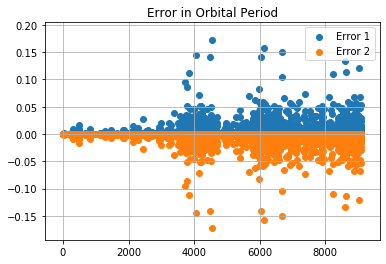

In [14]:
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["koi_period_err1"].values, label = "Error 1")
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["koi_period_err2"].values, label = "Error 2")
plt.title("Error in Orbital Period")
plt.grid()
plt.legend()

### Viewing Frequency Distribution

#### Positive Error

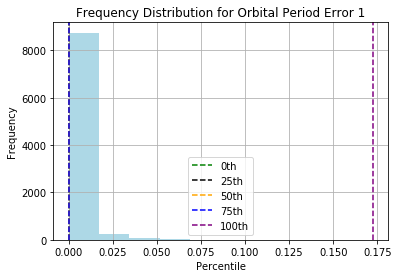

In [101]:
plt.hist(missing_error_values_df["koi_period_err1"].values, color = "lightblue")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_period_err1"].values, 0), color = "green", label = "0th", linestyle="--")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_period_err1"].values, 25), color = "black", label = "25th", linestyle="--")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_period_err1"].values, 50), color = "orange", label = "50th", linestyle="--")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_period_err1"].values, 75), color = "blue", label = "75th", linestyle="--")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_period_err1"].values, 100), color = "purple", label = "100th", linestyle="--")
plt.title("Frequency Distribution for Orbital Period Error 1")
plt.xlabel("Percentile")
plt.ylabel("Frequency")
plt.grid()
plt.legend()

In [110]:
df["koi_period_err1"].fillna(np.nanpercentile(missing_error_values_df["koi_period_err1"].values, 50), inplace = True)

#### Negative Error

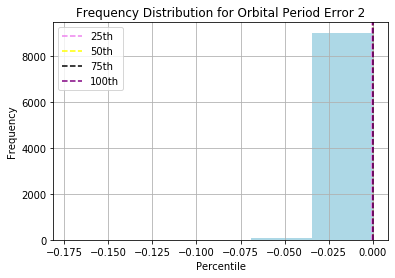

In [109]:
plt.hist(missing_error_values_df["koi_period_err2"].values, color="lightblue", bins = 5)
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_period_err2"].values, 25), color = "violet", label = "25th", linestyle="--")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_period_err2"].values, 50), color = "yellow", label = "50th", linestyle="--")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_period_err2"].values, 75), color = "black", label = "75th", linestyle="--")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_period_err2"].values, 100), color = "purple", label = "100th", linestyle="--")
plt.title("Frequency Distribution for Orbital Period Error 2")
plt.xlabel("Percentile")
plt.ylabel("Frequency")
plt.grid()
plt.legend()

In [111]:
df["koi_period_err2"].fillna(np.nanpercentile(missing_error_values_df["koi_period_err2"].values, 50), inplace = True)

## Replacing NaN in Transit Epoch

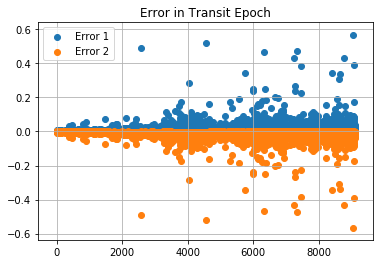

In [112]:
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["koi_time0bk_err1"].values, label = "Error 1")
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["koi_time0bk_err2"].values, label = "Error 2")
plt.title("Error in Transit Epoch")
plt.grid()
plt.legend()

### Viewing Frequency Distribution

#### Positive Error

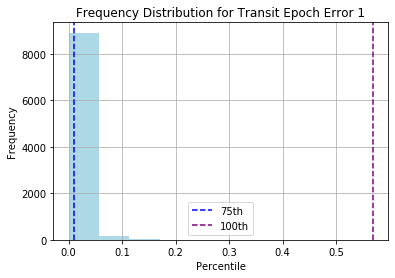

In [114]:
plt.hist(missing_error_values_df["koi_time0bk_err1"].values, color="lightblue")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_time0bk_err1"].values, 75), color = "blue", label = "75th", linestyle="--")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_time0bk_err1"].values, 100), color = "purple", label = "100th", linestyle="--")
plt.title("Frequency Distribution for Transit Epoch Error 1")
plt.xlabel("Percentile")
plt.ylabel("Frequency")
plt.grid()
plt.legend()

In [115]:
df["koi_time0bk_err1"].fillna(np.nanpercentile(missing_error_values_df["koi_time0bk_err1"].values, 50), inplace = True)

#### Negative Error

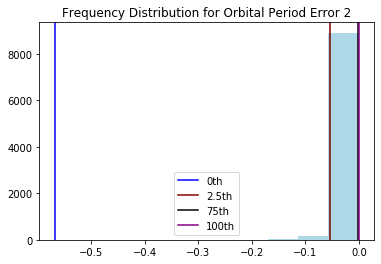

In [22]:
plt.hist(missing_error_values_df["koi_time0bk_err2"].values, color="lightblue")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_time0bk_err2"].values, 0), color = "blue", label = "0th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_time0bk_err2"].values, 2.5), color = "maroon", label = "2.5th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_time0bk_err2"].values, 75), color = "black", label = "75th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_time0bk_err2"].values, 100), color = "purple", label = "100th")
plt.title("Frequency Distribution for Orbital Period Error 2")
plt.legend()

In [23]:
df["koi_time0bk_err2"].fillna(np.nanpercentile(missing_error_values_df["koi_time0bk_err2"].values, 2.5), inplace = True)

## Replacing NaN in Impact Parameter

### Viewing Frequency Distribution

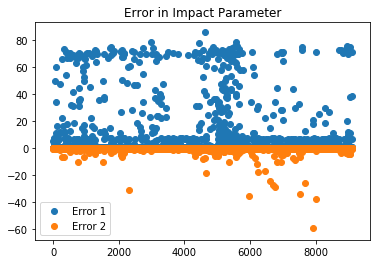

In [24]:
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["koi_impact_err1"].values, label = "Error 1")
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["koi_impact_err2"].values, label = "Error 2")
plt.title("Error in Impact Parameter")
plt.legend()

#### Positive Error

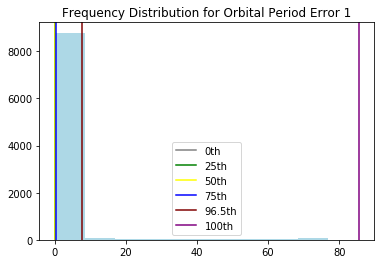

In [25]:
plt.hist(missing_error_values_df["koi_impact_err1"].values, color="lightblue")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_impact_err1"].values, 0), color = "grey", label = "0th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_impact_err1"].values, 25), color = "green", label = "25th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_impact_err1"].values, 50), color = "yellow", label = "50th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_impact_err1"].values, 75), color = "blue", label = "75th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_impact_err1"].values, 96.5), color = "maroon", label = "96.5th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_impact_err1"].values, 100), color = "purple", label = "100th")
plt.title("Frequency Distribution for Orbital Period Error 1")
plt.legend()

In [26]:
df["koi_impact_err1"].fillna(np.nanpercentile(missing_error_values_df["koi_impact_err1"].values, 96.5), inplace = True)

#### Negative Error

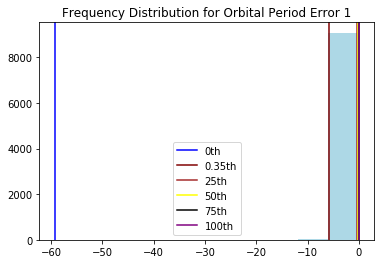

In [27]:
plt.hist(missing_error_values_df["koi_impact_err2"].values, color="lightblue")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_impact_err2"].values, 0), color = "blue", label = "0th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_impact_err2"].values, 0.35), color = "maroon", label = "0.35th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_impact_err2"].values, 25), color = "brown", label = "25th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_impact_err2"].values, 50), color = "yellow", label = "50th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_impact_err2"].values, 75), color = "black", label = "75th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_impact_err2"].values, 100), color = "purple", label = "100th")
plt.title("Frequency Distribution for Orbital Period Error 1")
plt.legend()

In [28]:
df["koi_impact_err2"].fillna(np.nanpercentile(missing_error_values_df["koi_impact_err2"].values, 0.35), inplace = True)

## Replacing NaN in Transit Duration

### Viewing Frequency Distribution

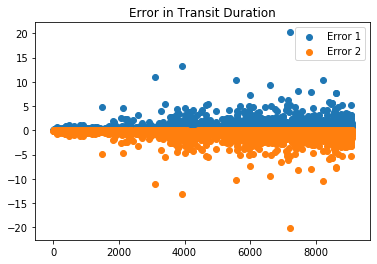

In [29]:
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["koi_duration_err1"].values, label = "Error 1")
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["koi_duration_err2"].values, label = "Error 2")
plt.title("Error in Transit Duration")
plt.legend()

#### Positive Error

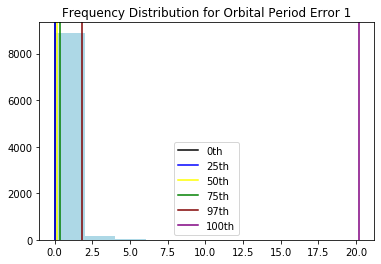

In [30]:
plt.hist(missing_error_values_df["koi_duration_err1"].values, color="lightblue")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_duration_err1"].values, 0), color = "black", label = "0th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_duration_err1"].values, 25), color = "blue", label = "25th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_duration_err1"].values, 50), color = "yellow", label = "50th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_duration_err1"].values, 75), color = "green", label = "75th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_duration_err1"].values, 97), color = "maroon", label = "97th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_duration_err1"].values, 100), color = "purple", label = "100th")
plt.title("Frequency Distribution for Orbital Period Error 1")
plt.legend()

In [31]:
df["koi_duration_err1"].fillna(np.nanpercentile(missing_error_values_df["koi_duration_err1"].values, 97), inplace = True)

#### Negative Error

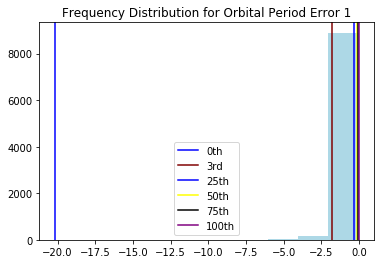

In [32]:
plt.hist(missing_error_values_df["koi_duration_err2"].values, color="lightblue")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_duration_err2"].values, 0), color = "blue", label = "0th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_duration_err2"].values, 3), color = "maroon", label = "3rd")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_duration_err2"].values, 25), color = "blue", label = "25th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_duration_err2"].values, 50), color = "yellow", label = "50th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_duration_err2"].values, 75), color = "black", label = "75th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_duration_err2"].values, 100), color = "purple", label = "100th")
plt.title("Frequency Distribution for Orbital Period Error 1")
plt.legend()

In [33]:
df["koi_duration_err2"].fillna(np.nanpercentile(missing_error_values_df["koi_duration_err2"].values, 3), inplace = True)

## Replacing NaN in Transit Depth

### Viewing Frequency Distribution

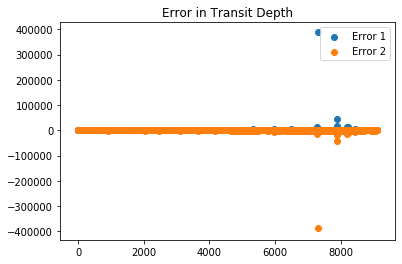

In [34]:
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["koi_depth_err1"].values, label = "Error 1")
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["koi_depth_err2"].values, label = "Error 2")
plt.title("Error in Transit Depth")
plt.legend()

#### Positive Error

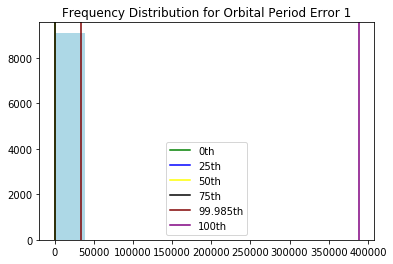

In [35]:
plt.hist(missing_error_values_df["koi_depth_err1"].values, color="lightblue")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_depth_err1"].values, 0), color = "green", label = "0th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_depth_err1"].values, 25), color = "blue", label = "25th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_depth_err1"].values, 50), color = "yellow", label = "50th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_depth_err1"].values, 75), color = "black", label = "75th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_depth_err1"].values, 99.985), color = "maroon", label = "99.985th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_depth_err1"].values, 100), color = "purple", label = "100th")
plt.title("Frequency Distribution for Orbital Period Error 1")
plt.legend()

In [36]:
df["koi_depth_err1"].fillna(np.nanpercentile(missing_error_values_df["koi_depth_err1"].values, 99.985), inplace = True)

#### Negative Error

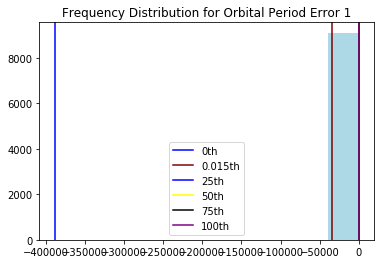

In [37]:
plt.hist(missing_error_values_df["koi_depth_err2"].values, color="lightblue")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_depth_err2"].values, 0), color = "blue", label = "0th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_depth_err2"].values, 0.015), color = "maroon", label = "0.015th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_depth_err2"].values, 25), color = "blue", label = "25th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_depth_err2"].values, 50), color = "yellow", label = "50th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_depth_err2"].values, 75), color = "black", label = "75th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_depth_err2"].values, 100), color = "purple", label = "100th")
plt.title("Frequency Distribution for Orbital Period Error 1")
plt.legend()

In [38]:
df["koi_depth_err2"].fillna(np.nanpercentile(missing_error_values_df["koi_depth_err2"].values, 0.015), inplace = True)

## Replacing NaN in Planet Radius

### Viewing Frequency Distribution

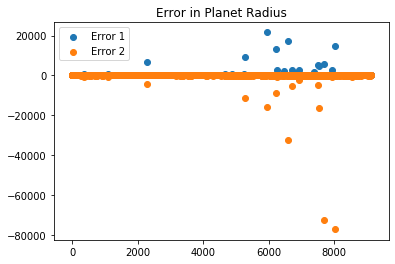

In [39]:
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["koi_prad_err1"].values, label = "Error 1")
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["koi_prad_err2"].values, label = "Error 2")
plt.title("Error in Planet Radius")
plt.legend()

#### Positive Error

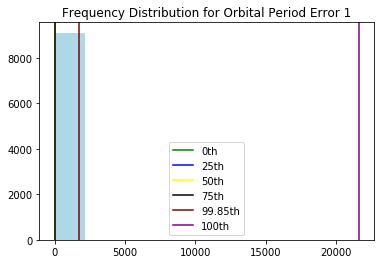

In [40]:
plt.hist(missing_error_values_df["koi_prad_err1"].values, color="lightblue")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_prad_err1"].values, 0), color = "green", label = "0th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_prad_err1"].values, 25), color = "blue", label = "25th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_prad_err1"].values, 50), color = "yellow", label = "50th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_prad_err1"].values, 75), color = "black", label = "75th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_prad_err1"].values, 99.85), color = "maroon", label = "99.85th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_prad_err1"].values, 100), color = "purple", label = "100th")
plt.title("Frequency Distribution for Orbital Period Error 1")
plt.legend()

In [41]:
df["koi_prad_err1"].fillna(np.nanpercentile(missing_error_values_df["koi_prad_err1"].values, 99.85), inplace = True)

#### Negative Error

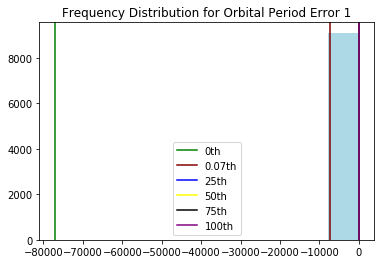

In [42]:
plt.hist(missing_error_values_df["koi_prad_err2"].values, color="lightblue")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_prad_err2"].values, 0), color = "green", label = "0th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_prad_err2"].values, 0.07), color = "maroon", label = "0.07th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_prad_err2"].values, 25), color = "blue", label = "25th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_prad_err2"].values, 50), color = "yellow", label = "50th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_prad_err2"].values, 75), color = "black", label = "75th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_prad_err2"].values, 100), color = "purple", label = "100th")
plt.title("Frequency Distribution for Orbital Period Error 1")
plt.legend()

In [43]:
df["koi_prad_err2"].fillna(np.nanpercentile(missing_error_values_df["koi_prad_err2"].values, 0.07), inplace = True)

## Replacing NaN in  Insolation Flux

### Viewing Frequency Distribution

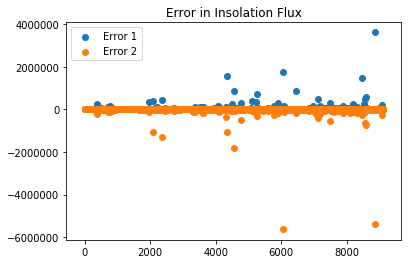

In [44]:
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["koi_insol_err1"].values, label = "Error 1")
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["koi_insol_err2"].values, label = "Error 2")
plt.title("Error in Insolation Flux")
plt.legend()

#### Positive Error

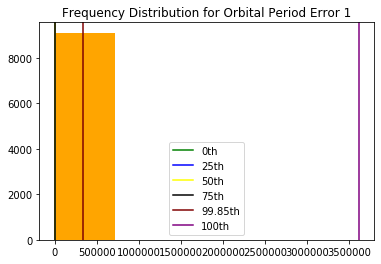

In [45]:
plt.hist(missing_error_values_df["koi_insol_err1"].values, bins=5, color="orange")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_insol_err1"].values, 0), color = "green", label = "0th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_insol_err1"].values, 25), color = "blue", label = "25th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_insol_err1"].values, 50), color = "yellow", label = "50th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_insol_err1"].values, 75), color = "black", label = "75th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_insol_err1"].values, 99.85), color = "maroon", label = "99.85th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_insol_err1"].values, 100), color = "purple", label = "100th")
plt.title("Frequency Distribution for Orbital Period Error 1")
plt.legend()

In [46]:
df["koi_insol_err1"].fillna(np.nanpercentile(missing_error_values_df["koi_insol_err1"].values, 99.85), inplace = True)

#### Negative Error

In [ ]:
plt.hist(missing_error_values_df["koi_insol_err2"].values, bins="auto", color="orange")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_insol_err2"].values, 0), color = "green", label = "0th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_insol_err2"].values, 0.1), color = "maroon", label = "0.1th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_insol_err2"].values, 50), color = "blue", label = "50th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_insol_err2"].values, 75), color = "black", label = "75th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_insol_err2"].values, 100), color = "purple", label = "100th")
plt.title("Frequency Distribution for Orbital Period Error 1")
plt.legend()

In [48]:
df["koi_insol_err2"].fillna(np.nanpercentile(missing_error_values_df["koi_insol_err2"].values, 0.1), inplace = True)

## Replacing NaN in Stellar Effective Temperature

### Viewing Frequency Distribution

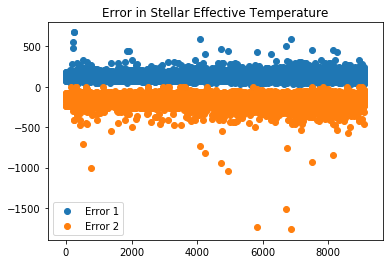

In [49]:
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["koi_steff_err1"].values, label = "Error 1")
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["koi_steff_err2"].values, label = "Error 2")
plt.title("Error in Stellar Effective Temperature")
plt.legend()

### Positive Error

C:\Anaconda37\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Anaconda37\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


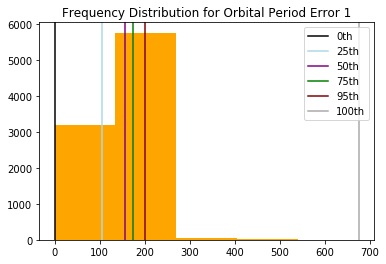

In [50]:
plt.hist(missing_error_values_df["koi_steff_err1"].values, bins=5, color="orange")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_steff_err1"].values, 0), color = "black", label = "0th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_steff_err1"].values, 25), color = "lightblue", label = "25th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_steff_err1"].values, 50), color = "purple", label = "50th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_steff_err1"].values, 75), color = "green", label = "75th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_steff_err1"].values, 95), color = "maroon", label = "95th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_steff_err1"].values, 100), color = "darkgrey", label = "100th")
plt.title("Frequency Distribution for Orbital Period Error 1")
plt.legend()

In [51]:
df["koi_steff_err1"].fillna(np.nanpercentile(missing_error_values_df["koi_steff_err1"].values, 95), inplace = True)

### Negative Error

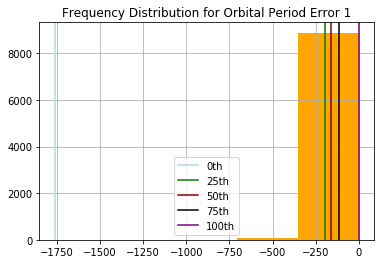

In [52]:
plt.hist(missing_error_values_df["koi_steff_err2"].values, bins=5, color="orange")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_steff_err2"].values, 0), color = "lightblue", label = "0th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_steff_err2"].values, 25), color = "green", label = "25th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_steff_err2"].values, 50), color = "maroon", label = "50th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_steff_err2"].values, 75), color = "black", label = "75th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_steff_err2"].values, 100), color = "purple", label = "100th")
plt.title("Frequency Distribution for Orbital Period Error 1")
plt.grid()
plt.legend()


In [53]:
df["koi_steff_err2"].fillna(np.nanpercentile(missing_error_values_df["koi_steff_err2"].values, 50), inplace = True)

## Replacing NaN in Surface Gravity

### Viewing Frequency Distribution

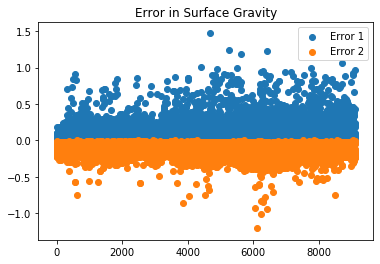

In [54]:
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["koi_slogg_err1"].values, label = "Error 1")
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["koi_slogg_err2"].values, label = "Error 2")
plt.title("Error in Surface Gravity")
plt.legend()

#### Positive Error

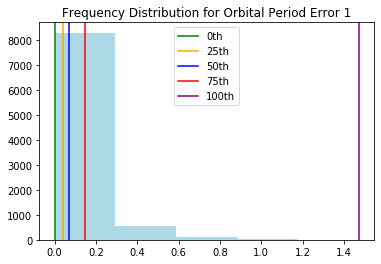

In [55]:
plt.hist(missing_error_values_df["koi_slogg_err1"].values, bins=5, color="lightblue")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_slogg_err1"].values, 0), color = "green", label = "0th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_slogg_err1"].values, 25), color = "orange", label = "25th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_slogg_err1"].values, 50), color = "blue", label = "50th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_slogg_err1"].values, 75), color = "red", label = "75th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_slogg_err1"].values, 100), color = "purple", label = "100th")
plt.title("Frequency Distribution for Orbital Period Error 1")
plt.legend()


In [56]:
df["koi_slogg_err1"].fillna(np.nanpercentile(missing_error_values_df["koi_slogg_err1"].values, 75), inplace = True)

#### Negative Error

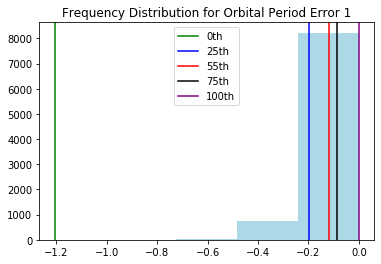

In [57]:
plt.hist(missing_error_values_df["koi_slogg_err2"].values, bins=5, color = "lightblue")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_slogg_err2"].values, 0), color = "green", label = "0th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_slogg_err2"].values, 25), color = "blue", label = "25th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_slogg_err2"].values, 55), color = "red", label = "55th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_slogg_err2"].values, 75), color = "black", label = "75th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_slogg_err2"].values, 100), color = "purple", label = "100th")
plt.title("Frequency Distribution for Orbital Period Error 1")
plt.legend()


In [58]:
df["koi_slogg_err2"].fillna(np.nanpercentile(missing_error_values_df["koi_slogg_err2"].values, 55), inplace = True)

## Replacing NaN in Stellar Radius

### Viewing Frequency Distribution

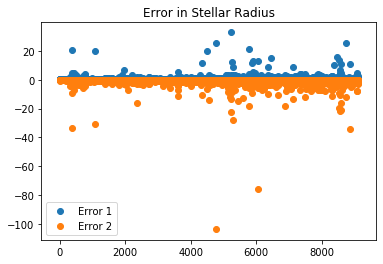

In [59]:
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["koi_srad_err1"].values, label = "Error 1")
plt.scatter(range(missing_error_values_df.shape[0]), missing_error_values_df["koi_srad_err2"].values, label = "Error 2")
plt.title("Error in Stellar Radius")
plt.legend()

#### Positive Error

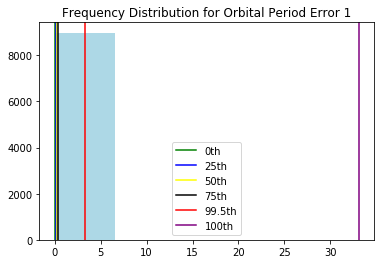

In [60]:
plt.hist(missing_error_values_df["koi_srad_err1"].values, bins=5, color="lightblue")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_srad_err1"].values, 0), color = "green", label = "0th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_srad_err1"].values, 25), color = "blue", label = "25th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_srad_err1"].values, 50), color = "yellow", label = "50th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_srad_err1"].values, 75), color = "black", label = "75th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_srad_err1"].values, 99.5), color = "red", label = "99.5th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_srad_err1"].values, 100), color = "purple", label = "100th")
plt.title("Frequency Distribution for Orbital Period Error 1")
plt.legend()


In [61]:
df["koi_srad_err1"].fillna(np.nanpercentile(missing_error_values_df["koi_srad_err1"].values, 99.5), inplace = True)

#### Negative Error

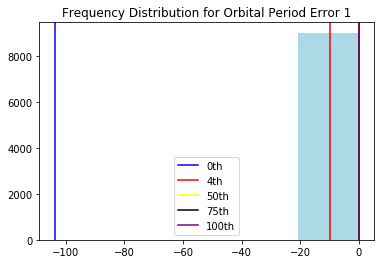

In [62]:
plt.hist(missing_error_values_df["koi_srad_err2"].values, bins=5, color="lightblue")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_srad_err2"].values, 0), color = "blue", label = "0th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_srad_err2"].values, 0.3), color = "red", label = "4th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_srad_err2"].values, 50), color = "yellow", label = "50th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_srad_err2"].values, 75), color = "black", label = "75th")
plt.axvline(x = np.nanpercentile(missing_error_values_df["koi_srad_err2"].values, 100), color = "purple", label = "100th")
plt.title("Frequency Distribution for Orbital Period Error 1")
plt.legend()


In [63]:
df["koi_srad_err2"].fillna(np.nanpercentile(missing_error_values_df["koi_srad_err2"].values, 0.3), inplace = True)

## Finding Errors in Non-Error Attributes

In [64]:
nan_columns = df.isnull().sum()
nan_columns = {col:count for col, count in nan_columns.items() if count >0}
pp.pprint(nan_columns)

{  'koi_kepmag': 1,
   'koi_score': 1206,
   'koi_tce_delivname': 255,
   'koi_tce_plnt_num': 255}


In [65]:
nan_columns = df.isnull().sum()
nan_columns = {col:count for col, count in nan_columns.items() if count >0}
pp.pprint(nan_columns)

{  'koi_kepmag': 1,
   'koi_score': 1206,
   'koi_tce_delivname': 255,
   'koi_tce_plnt_num': 255}


### Removing NaN in Depth

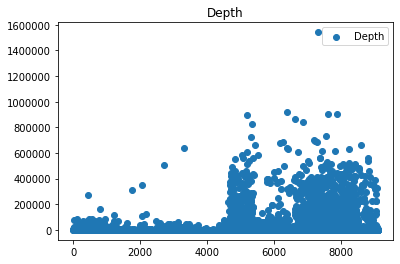

In [66]:
plt.scatter(range(df.shape[0]), df["koi_depth"].values, label = "Depth")
plt.title("Depth")
plt.legend()

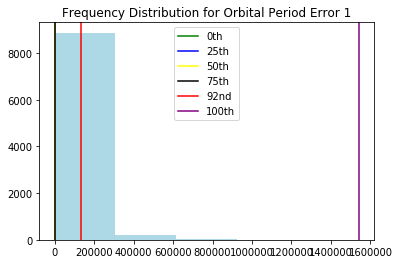

In [67]:
plt.hist(df["koi_depth"].values, bins=5, color="lightblue")
plt.axvline(x = np.nanpercentile(df["koi_depth"].values, 0), color = "green", label = "0th")
plt.axvline(x = np.nanpercentile(df["koi_depth"].values, 25), color = "blue", label = "25th")
plt.axvline(x = np.nanpercentile(df["koi_depth"].values, 50), color = "yellow", label = "50th")
plt.axvline(x = np.nanpercentile(df["koi_depth"].values, 75), color = "black", label = "75th")
plt.axvline(x = np.nanpercentile(df["koi_depth"].values, 94), color = "red", label = "92nd")
plt.axvline(x = np.nanpercentile(df["koi_depth"].values, 100), color = "purple", label = "100th")
plt.title("Frequency Distribution for Orbital Period Error 1")
plt.legend()


In [68]:
df["koi_depth"].fillna(np.nanpercentile(df["koi_depth"].values, 92), inplace = True)

## Removing NaN in Impact Parameter

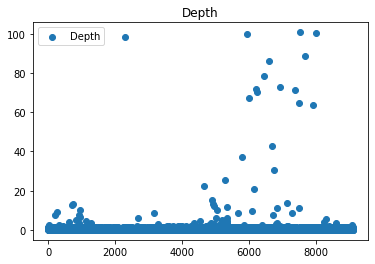

In [69]:
plt.scatter(range(df.shape[0]), df["koi_impact"].values, label = "Depth")
plt.title("Depth")
plt.legend()

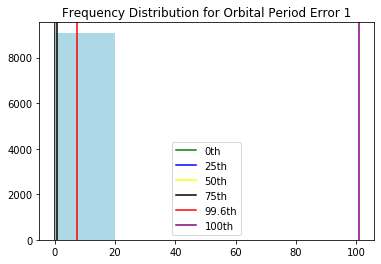

In [70]:
plt.hist(df["koi_impact"].values, bins=5, color="lightblue")
plt.axvline(x = np.nanpercentile(df["koi_impact"].values, 0), color = "green", label = "0th")
plt.axvline(x = np.nanpercentile(df["koi_impact"].values, 25), color = "blue", label = "25th")
plt.axvline(x = np.nanpercentile(df["koi_impact"].values, 50), color = "yellow", label = "50th")
plt.axvline(x = np.nanpercentile(df["koi_impact"].values, 75), color = "black", label = "75th")
plt.axvline(x = np.nanpercentile(df["koi_impact"].values, 99.6), color = "red", label = "99.6th")
plt.axvline(x = np.nanpercentile(df["koi_impact"].values, 100), color = "purple", label = "100th")
plt.title("Frequency Distribution for Orbital Period Error 1")
plt.legend()


In [71]:
df["koi_impact"].fillna(np.nanpercentile(df["koi_impact"].values, 99.6), inplace = True)

## Replacing NaN in Insolation Flux

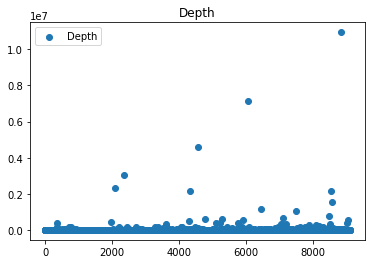

In [72]:
plt.scatter(range(df.shape[0]), df["koi_insol"].values, label = "Depth")
plt.title("Depth")
plt.legend()

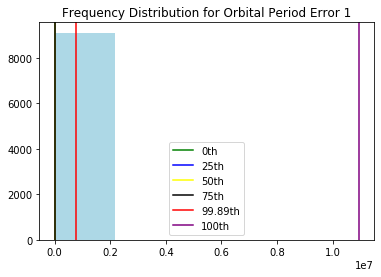

In [73]:
plt.hist(df["koi_insol"].values, bins=5, color="lightblue")
plt.axvline(x = np.nanpercentile(df["koi_insol"].values, 0), color = "green", label = "0th")
plt.axvline(x = np.nanpercentile(df["koi_insol"].values, 25), color = "blue", label = "25th")
plt.axvline(x = np.nanpercentile(df["koi_insol"].values, 50), color = "yellow", label = "50th")
plt.axvline(x = np.nanpercentile(df["koi_insol"].values, 75), color = "black", label = "75th")
plt.axvline(x = np.nanpercentile(df["koi_insol"].values, 99.89), color = "red", label = "99.89th")
plt.axvline(x = np.nanpercentile(df["koi_insol"].values, 100), color = "purple", label = "100th")
plt.title("Frequency Distribution for Orbital Period Error 1")
plt.legend()


In [74]:
df["koi_insol"].fillna(np.nanpercentile(df["koi_insol"].values, 99.89), inplace = True)

## Replacing NaN in Kep Mag

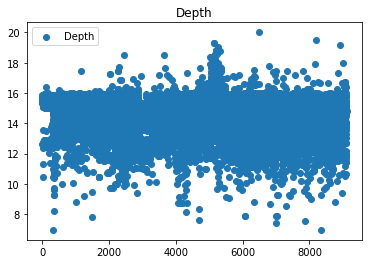

In [75]:
plt.scatter(range(df.shape[0]), df["koi_kepmag"].values, label = "Depth")
plt.title("Depth")
plt.legend()

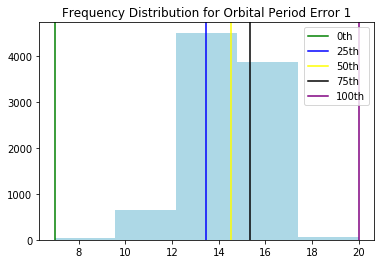

In [76]:
plt.hist(df["koi_kepmag"].values, bins=5, color="lightblue")
plt.axvline(x = np.nanpercentile(df["koi_kepmag"].values, 0), color = "green", label = "0th")
plt.axvline(x = np.nanpercentile(df["koi_kepmag"].values, 25), color = "blue", label = "25th")
plt.axvline(x = np.nanpercentile(df["koi_kepmag"].values, 50), color = "yellow", label = "50th")
plt.axvline(x = np.nanpercentile(df["koi_kepmag"].values, 75), color = "black", label = "75th")
plt.axvline(x = np.nanpercentile(df["koi_kepmag"].values, 100), color = "purple", label = "100th")
plt.title("Frequency Distribution for Orbital Period Error 1")
plt.legend()


In [77]:
df["koi_kepmag"].fillna(np.nanpercentile(df["koi_kepmag"].values, 25), inplace = True)

## Replacing NaN in SNR

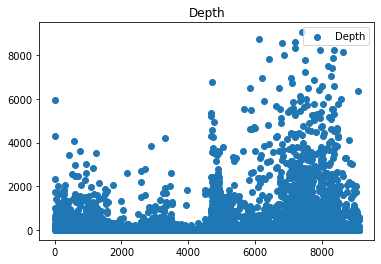

In [78]:
plt.scatter(range(df.shape[0]), df["koi_model_snr"].values, label = "Depth")
plt.title("Depth")
plt.legend()

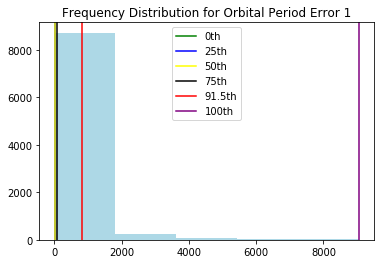

In [79]:
plt.hist(df["koi_model_snr"].values, bins=5, color="lightblue")
plt.axvline(x = np.nanpercentile(df["koi_model_snr"].values, 0), color = "green", label = "0th")
plt.axvline(x = np.nanpercentile(df["koi_model_snr"].values, 25), color = "blue", label = "25th")
plt.axvline(x = np.nanpercentile(df["koi_model_snr"].values, 50), color = "yellow", label = "50th")
plt.axvline(x = np.nanpercentile(df["koi_model_snr"].values, 75), color = "black", label = "75th")
plt.axvline(x = np.nanpercentile(df["koi_model_snr"].values, 91.5), color = "red", label = "91.5th")
plt.axvline(x = np.nanpercentile(df["koi_model_snr"].values, 100), color = "purple", label = "100th")
plt.title("Frequency Distribution for Orbital Period Error 1")
plt.legend()


In [80]:
df["koi_model_snr"].fillna(np.nanpercentile(df["koi_model_snr"].values, 91.5), inplace = True)

## Replacing NaN in Planet Radius

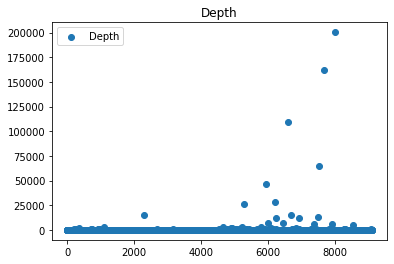

In [81]:
plt.scatter(range(df.shape[0]), df["koi_prad"].values, label = "Depth")
plt.title("Depth")
plt.legend()

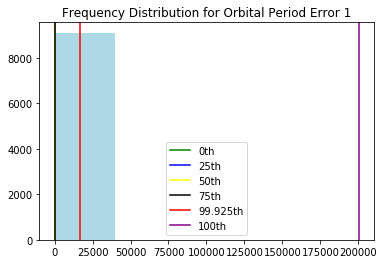

In [82]:
plt.hist(df["koi_prad"].values, bins=5, color="lightblue")
plt.axvline(x = np.nanpercentile(df["koi_prad"].values, 0), color = "green", label = "0th")
plt.axvline(x = np.nanpercentile(df["koi_prad"].values, 25), color = "blue", label = "25th")
plt.axvline(x = np.nanpercentile(df["koi_prad"].values, 50), color = "yellow", label = "50th")
plt.axvline(x = np.nanpercentile(df["koi_prad"].values, 75), color = "black", label = "75th")
plt.axvline(x = np.nanpercentile(df["koi_prad"].values, 99.925), color = "red", label = "99.925th")
plt.axvline(x = np.nanpercentile(df["koi_prad"].values, 100), color = "purple", label = "100th")
plt.title("Frequency Distribution for Orbital Period Error 1")
plt.legend()


In [83]:
df["koi_prad"].fillna(np.nanpercentile(df["koi_prad"].values, 99.925), inplace = True)

## Replacing NaN in Score

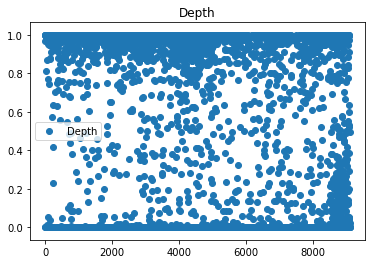

In [84]:
plt.scatter(range(df.shape[0]), df["koi_score"].values, label = "Depth")
plt.title("Depth")
plt.legend()

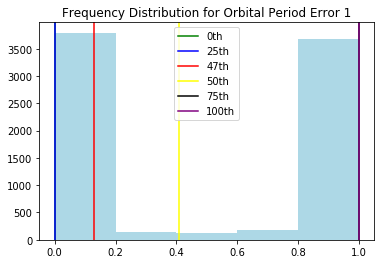

In [85]:
plt.hist(df["koi_score"].values, bins=5, color="lightblue")
plt.axvline(x = np.nanpercentile(df["koi_score"].values, 0), color = "green", label = "0th")
plt.axvline(x = np.nanpercentile(df["koi_score"].values, 25), color = "blue", label = "25th")
plt.axvline(x = np.nanpercentile(df["koi_score"].values, 47), color = "red", label = "47th")
plt.axvline(x = np.nanpercentile(df["koi_score"].values, 50), color = "yellow", label = "50th")
plt.axvline(x = np.nanpercentile(df["koi_score"].values, 75), color = "black", label = "75th")
plt.axvline(x = np.nanpercentile(df["koi_score"].values, 100), color = "purple", label = "100th")
plt.title("Frequency Distribution for Orbital Period Error 1")
plt.legend()


In [86]:
df["koi_score"].fillna(np.nanpercentile(df["koi_score"].values, 47), inplace = True)

## Replacing NaN in Gravitation

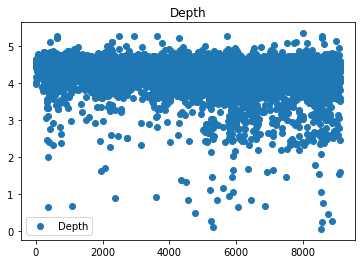

In [87]:
plt.scatter(range(df.shape[0]), df["koi_slogg"].values, label = "Depth")
plt.title("Depth")
plt.legend()

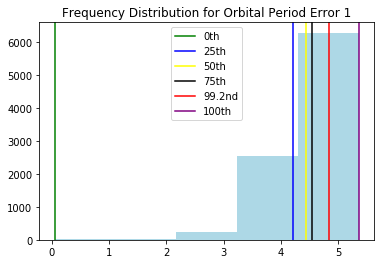

In [88]:
plt.hist(df["koi_slogg"].values, bins=5, color="lightblue")
plt.axvline(x = np.nanpercentile(df["koi_slogg"].values, 0), color = "green", label = "0th")
plt.axvline(x = np.nanpercentile(df["koi_slogg"].values, 25), color = "blue", label = "25th")
plt.axvline(x = np.nanpercentile(df["koi_slogg"].values, 50), color = "yellow", label = "50th")
plt.axvline(x = np.nanpercentile(df["koi_slogg"].values, 75), color = "black", label = "75th")
plt.axvline(x = np.nanpercentile(df["koi_slogg"].values, 99.2), color = "red", label = "99.2nd")
plt.axvline(x = np.nanpercentile(df["koi_slogg"].values, 100), color = "purple", label = "100th")
plt.title("Frequency Distribution for Orbital Period Error 1")
plt.legend()


In [89]:
df["koi_slogg"].fillna(np.nanpercentile(df["koi_slogg"].values, 99.2), inplace = True)

## Replacing NaN in Stellar Radius

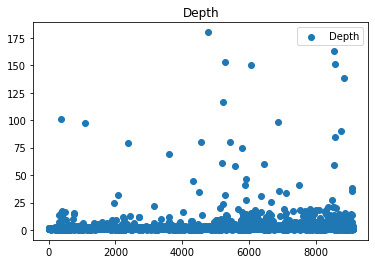

In [90]:
plt.scatter(range(df.shape[0]), df["koi_srad"].values, label = "Depth")
plt.title("Depth")
plt.legend()

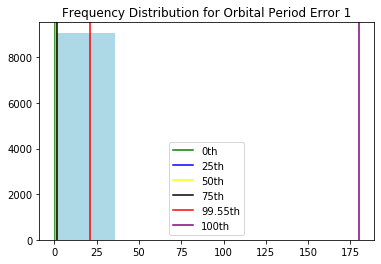

In [91]:
plt.hist(df["koi_srad"].values, bins=5, color="lightblue")
plt.axvline(x = np.nanpercentile(df["koi_srad"].values, 0), color = "green", label = "0th")
plt.axvline(x = np.nanpercentile(df["koi_srad"].values, 25), color = "blue", label = "25th")
plt.axvline(x = np.nanpercentile(df["koi_srad"].values, 50), color = "yellow", label = "50th")
plt.axvline(x = np.nanpercentile(df["koi_srad"].values, 75), color = "black", label = "75th")
plt.axvline(x = np.nanpercentile(df["koi_srad"].values, 99.55), color = "red", label = "99.55th")
plt.axvline(x = np.nanpercentile(df["koi_srad"].values, 100), color = "purple", label = "100th")
plt.title("Frequency Distribution for Orbital Period Error 1")
plt.legend()


In [92]:
df["koi_srad"].fillna(np.nanpercentile(df["koi_srad"].values, 99.55), inplace = True)

## Replacing NaN in Steff

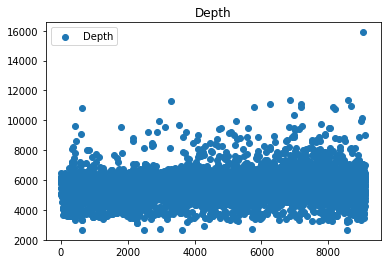

In [93]:
plt.scatter(range(df.shape[0]), df["koi_steff"].values, label = "Depth")
plt.title("Depth")
plt.legend()

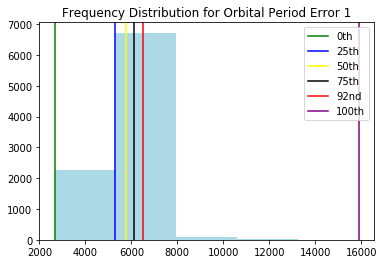

In [94]:
plt.hist(df["koi_steff"].values, bins=5, color="lightblue")
plt.axvline(x = np.nanpercentile(df["koi_steff"].values, 0), color = "green", label = "0th")
plt.axvline(x = np.nanpercentile(df["koi_steff"].values, 25), color = "blue", label = "25th")
plt.axvline(x = np.nanpercentile(df["koi_steff"].values, 50), color = "yellow", label = "50th")
plt.axvline(x = np.nanpercentile(df["koi_steff"].values, 75), color = "black", label = "75th")
plt.axvline(x = np.nanpercentile(df["koi_steff"].values, 92), color = "red", label = "92nd")
plt.axvline(x = np.nanpercentile(df["koi_steff"].values, 100), color = "purple", label = "100th")
plt.title("Frequency Distribution for Orbital Period Error 1")
plt.legend()


In [95]:
df["koi_steff"].fillna(np.nanpercentile(df["koi_steff"].values, 92), inplace = True)

## Replacing NaN in Equilibrium Temperature

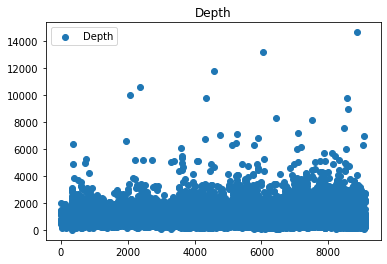

In [96]:
plt.scatter(range(df.shape[0]), df["koi_teq"].values, label = "Depth")
plt.title("Depth")
plt.legend()

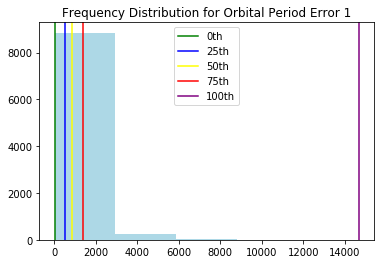

In [97]:
plt.hist(df["koi_teq"].values, bins=5, color="lightblue")
plt.axvline(x = np.nanpercentile(df["koi_teq"].values, 0), color = "green", label = "0th")
plt.axvline(x = np.nanpercentile(df["koi_teq"].values, 25), color = "blue", label = "25th")
plt.axvline(x = np.nanpercentile(df["koi_teq"].values, 50), color = "yellow", label = "50th")
plt.axvline(x = np.nanpercentile(df["koi_teq"].values, 75), color = "red", label = "75th")
plt.axvline(x = np.nanpercentile(df["koi_teq"].values, 100), color = "purple", label = "100th")
plt.title("Frequency Distribution for Orbital Period Error 1")
plt.legend()


In [98]:
df["koi_teq"].fillna(np.nanpercentile(df["koi_teq"].values, 75), inplace = True)

# Re-Counting NaNs

In [99]:
nan_columns = df.isnull().sum()
nan_columns = {col:count for col, count in nan_columns.items() if count >0}
pp.pprint(nan_columns)

{'koi_tce_delivname': 255, 'koi_tce_plnt_num': 255}


# Saving Cleaned Dataset

In [100]:
#df.to_csv("[CLEANED]kepler-data.csv")